In [13]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np 
import s3fs 
import glob 
import warnings

In [3]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [5]:
dset = open_s3fs('PC-data')
dset 

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [77]:
dx = 10 
dy = 10 

In [139]:
u = dset.vozocrtx.sel(y=slice(800,1800), x=slice(200,1400))
v = dset.vomecrty.sel(y=slice(800,1800), x=slice(200,1400))
uv = dset.vel.sel(y=slice(800,1800), x=slice(200,1400))

In [140]:
u.shape

(75, 1000, 1200)

In [141]:
# chooseing a level to look at 
level_list = [0, 7, 14, 20, 35, 50, 60]
depth_list = np.zeros(7)
for i, level in enumerate(level_list):
    depth = dset.depth[level].values
    depth_list[i] = depth
#print(depth_list)

In [142]:
# funcktion for rolling mean 
def running_mean(x, N):
    out = np.zeros_like(x, dtype=np.float64)
    dim_len = x.shape[0]
    for i in range(dim_len):
        if N%2 == 0:
            a, b = i - (N-1)//2, i + (N-1)//2 + 2
        else:
            a, b = i - (N-1)//2, i + (N-1)//2 + 1

        #cap indices to min and max indices
        a = max(0, a)
        b = min(dim_len, b)
        out[i] = np.mean(x[a:b])
    return out

In [143]:
dx = 10 
dy = 10 
jmax, imax = uv[0].shape #fetches the max value in j and i direction 
i_list = np.arange(0,imax,dx)
j_list = np.arange(0,jmax,dy)

In [144]:
print(j_list.shape)
print(i_list.shape)
print(78*120)

(100,)
(120,)
9360


In [145]:
 # to get the loop to run faster
uvy = np.array(uv.y.values)
uvx = np.array(uv.x.values)
    
# fetching the varaibel at the given level 
uvar_depth = np.array(u[0,:,:].values)
vvar_depth = np.array(v[0,:,:].values)
uv_depth = np.array(uv[0,:,:].values)

In [146]:
PC11 = []
PC12 = []
PC21 = []
PC22 = []
x = []
y = []

for i in i_list:
    for j in j_list:
        covm = np.array([[uvar_depth[j,i],uv_depth[j,i]],
        [uv_depth[j,i],vvar_depth[j,i]]],dtype=float)
        if np.isnan(covm).any():
            continue
        else:
            values, vectors = np.linalg.eig(covm)
            PC11.append(vectors[0,0]*np.sqrt(values[0]))
            PC12.append(vectors[1,0]*np.sqrt(values[0]))
            PC21.append(vectors[0,1]*np.sqrt(values[1]))
            PC22.append(vectors[1,1]*np.sqrt(values[1]))
            y.append(uvy[j])
            x.append(uvx[i])
            indx = indx + 1

In [135]:
len(PC11)

7114

In [97]:
 # Making the covmatrix and finding the eigenvalues and eigenvectors
# list of all the points for the PC-crosses
'Dont remember how I got to this number, so dont know how to change the number of points in each PC'
PC11 = np.zeros(7114)#3379
PC12 = np.zeros(7114) #7114
PC21 = np.zeros(7114)
PC22 = np.zeros(7114)
y = np.zeros(7114)
x = np.zeros(7114)
indx = 0

In [114]:
for i in i_list:
        for j in j_list:
            covm = np.array([[uvar_depth[j,i],uv_depth[j,i]],
            [uv_depth[j,i],vvar_depth[j,i]]],dtype=float)
            if np.isnan(covm).any():
                continue
            else:
                values, vectors = np.linalg.eig(covm)
                PC11[int(indx)] = vectors[0,0]*np.sqrt(values[0])
                PC12[int(indx)] = vectors[1,0]*np.sqrt(values[0])
                PC21[int(indx)] = vectors[0,1]*np.sqrt(values[1])
                PC22[int(indx)] = vectors[1,1]*np.sqrt(values[1])
                y[int(indx)] = uvy[j]
                x[int(indx)] = uvx[i]
                indx = indx + 1

IndexError: list assignment index out of range

array([0.        , 0.0205524 , 0.01788727, ..., 0.        , 0.        ,
       0.        ])

In [147]:
# converting to np.arrays
PC11 = np.array(PC11,dtype=float)
PC12 = np.array(PC12,dtype=float)
PC21 = np.array(PC21,dtype=float)
PC22 = np.array(PC22,dtype=float)
y = np.array(y,dtype=float)
x = np.array(x,dtype=float)
    
# smoothening the data
PC11 = running_mean(PC11, 10)
PC12 = running_mean(PC12, 10)
PC21 = running_mean(PC21, 10)
PC22 = running_mean(PC22, 10)
    

'A funcktion for constructing PC at a given level '
def PC_funk(level):
    warnings.filterwarnings('ignore')
    
    #dx = 20
    #dy = 20
    
    # Making empty list with size as data-points 
    jmax, imax = uv[0].shape #fetches the max value in j and i direction 
    i_list = np.arange(0,imax,dx)
    j_list = np.arange(0,jmax,dy)
    
    # Making the covmatrix and finding the eigenvalues and eigenvectors
    # list of all the points for the PC-crosses
    'Dont remember how I got to this number, so dont know how to change the number of points in each PC'
    PC11 = np.zeros(3379)
    PC12 = np.zeros(3379)
    PC21 = np.zeros(3379)
    PC22 = np.zeros(3379)
    y = np.zeros(3379)
    x = np.zeros(3379)
    indx = 0
    
    # to get the loop to run faster
    uvy = np.array(uv.y.values)
    uvx = np.array(uv.x.values)
    
    # fetching the varaibel at the given level 
    uvar_depth = np.array(u[level,:,:].values)
    vvar_depth = np.array(v[level,:,:].values)
    uv_depth = np.array(uv[level,:,:].values)
    
    for i in i_list:
        for j in j_list:
            covm = np.array([[uvar_depth[j,i],uv_depth[j,i]],
            [uv_depth[j,i],vvar_depth[j,i]]],dtype=float)
            if np.isnan(covm).any():
                continue
            else:
                values, vectors = np.linalg.eig(covm)
                PC11[int(indx)] = vectors[0,0]*np.sqrt(values[0])
                PC12[int(indx)] = vectors[1,0]*np.sqrt(values[0])
                PC21[int(indx)] = vectors[0,1]*np.sqrt(values[1])
                PC22[int(indx)] = vectors[1,1]*np.sqrt(values[1])
                y[int(indx)] = uvy[j]
                x[int(indx)] = uvx[i]
                indx = indx + 1
                
    # converting to np.arrays
    PC11 = np.array(PC11,dtype=float)
    PC12 = np.array(PC12,dtype=float)
    PC21 = np.array(PC21,dtype=float)
    PC22 = np.array(PC22,dtype=float)
    y = np.array(y,dtype=float)
    x = np.array(x,dtype=float)
    
    # smoothening the data
    PC11 = running_mean(PC11, 10)
    PC12 = running_mean(PC12, 10)
    PC21 = running_mean(PC21, 10)
    PC22 = running_mean(PC22, 10)
    
    return PC11, PC12, PC21, PC22, x, y 

In [148]:
styrke_1 = np.sqrt(PC11**2 + PC12**2)
styrke_2 = np.sqrt(PC21**2 + PC22**2)

styrke_midlet = np.sqrt(styrke_1**2 + styrke_2**2)
styrke_midlet.shape

(7114,)

In [150]:
dset.mbathy.shape

(1801, 1580)

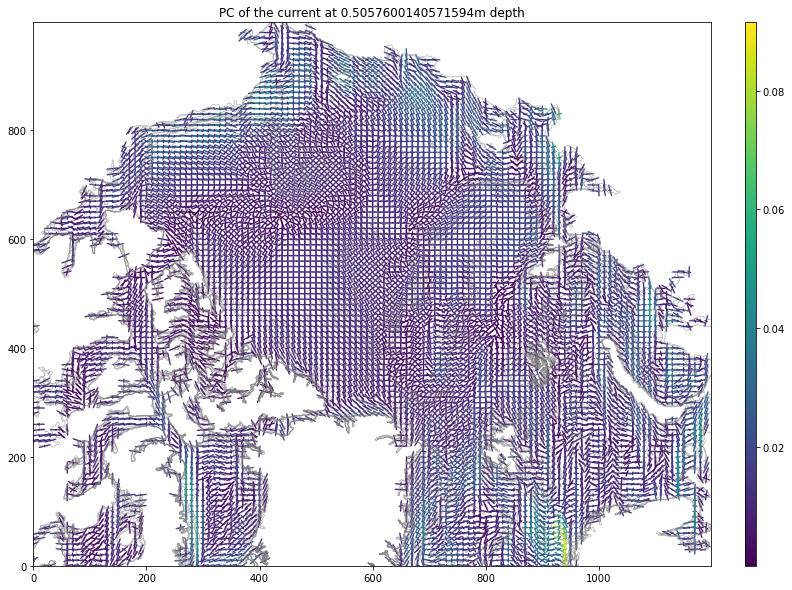

In [155]:
# Plot level 1

fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
cmap = plt.get_cmap('magma_r')
ax.contour(dset.mbathy[800:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
c = ax.quiver( x, y, PC11/styrke_midlet, PC12/styrke_midlet, 
    #color='r',
    styrke_1,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver(x, y, -PC11/styrke_midlet, -PC12/styrke_midlet,
    #color='r',
    styrke_1,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver( x, y, PC21/styrke_midlet, PC22/styrke_midlet,
    #color='b',
    styrke_2,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver( x, y, -PC21/styrke_midlet, -PC22/styrke_midlet,
    #color='b',
    styrke_2,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
#ax.set_xlim(200,1400)
#ax.set_ylim(800,1800)

fig.colorbar(c,orientation='vertical', pad = 0.04, aspect=50, extendrect=True)
